# 모델의 종류에 따른 노이즈 데이터 특징 학습 변화 분석

노이즈 종류에 따라 드리프트 현상이 모델에 미치는 영향도의 양상이 모델에 따라 달라질 수 있는가 실험

## 실험 대상 데이터

각 타입의 노이즈 적용 데이터셋 및 복합 노이즈 데이터셋

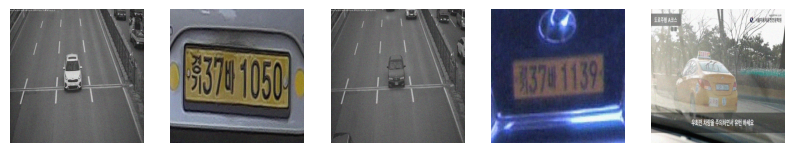

In [1]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

noise_types = ['gaus', 'snp', 'motion_blur', 'jpeg_compression', 'bright', 'dark', 'noise_composite']

test_dataset_path = f"../datasets/{noise_types[0]}_current/images/train/"
# 이미지 파일 목록 가져오기
image_files = [f for f in os.listdir(test_dataset_path) if os.path.isfile(os.path.join(test_dataset_path, f))]

# 랜덤하게 5장 선택
random_images = random.sample(image_files, 5)

# 이미지 시각화
plt.figure(figsize=(10, 10))
for i, image_file in enumerate(random_images):
    img = mpimg.imread(os.path.join(test_dataset_path, image_file))
    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.axis('off')
plt.show()


### 데이터셋 변환 기능 테스트

In [31]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

class YoloDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = []

        # train, valid, test 디렉토리의 이미지 파일을 모두 수집
        for phase in ['train', 'val', 'test']:
            phase_dir = os.path.join(root_dir, 'images', phase)
            print(f"inserting dir : {phase_dir}")
            self.image_files.extend(
                [os.path.join(phase_dir, f) for f in os.listdir(phase_dir) if f.endswith('.jpg')]
            )
            print(f"inserted {len(self.image_files)} images")
            print()

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]

        img_dir = os.path.dirname(img_path)
        img_name = os.path.basename(img_path)
        label_dir = img_dir.replace('images', 'labels')
        label_path = os.path.join(label_dir, os.path.splitext(img_name)[0] + '.txt')
        # print(f"label_path : {label_path}")
        
        # 이미지 로드
        image = Image.open(img_path).convert('RGB')
        width, height = image.size
        
        boxes = []
        labels = []
        
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                for line in f:
                    data = line.strip().split()
                    if len(data) == 5:  # YOLO 형식: class x_center y_center width height
                        class_id = int(data[0])
                        x_center = float(data[1])
                        y_center = float(data[2])
                        width = float(data[3])
                        height = float(data[4])
                        
                        # [xmin, ymin, xmax, ymax] 형식으로 변환
                        xmin = x_center - width/2
                        ymin = y_center - height/2
                        xmax = x_center + width/2
                        ymax = y_center + height/2
                        
                        boxes.append([xmin, ymin, xmax, ymax])
                        labels.append(class_id + 1)  # 0은 배경 클래스로 사용
        
        # 텐서로 변환
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        
        # 변환 적용
        if self.transform:
            image = self.transform(image)
        
        target = {
            'boxes': boxes,
            'labels': labels
        }
        
        return image, target 
    
def collate_fn(batch):
    images = [item[0] for item in batch]
    targets = [item[1] for item in batch]
    
    return images, targets

### 학습 루프 테스트

In [32]:
import torch
import torchvision
from torchvision.models.detection import (
    FasterRCNN,
    RetinaNet,
    FCOS,
    SSDLite320_MobileNet_V3_Large_Weights
)
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
from torch.utils.data import DataLoader, random_split, Subset
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.tensorboard import SummaryWriter
from torchmetrics.detection import MeanAveragePrecision
import time
import json
from pathlib import Path
import logging
import numpy as np

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

class VisionModelExperiment:
    def __init__(self, num_classes, device='cuda', val_ratio=0.2):
        self.num_classes = num_classes
        self.device = device
        self.val_ratio = val_ratio
        self.models = {}
        self.results = {}
        self.writers = {}
        
    def split_dataset(self, dataset, val_ratio=0.2, seed=42):
        """데이터셋을 학습용과 검증용으로 분할"""
        # 데이터셋 크기 계산
        total_size = len(dataset)
        val_size = int(total_size * val_ratio)
        train_size = total_size - val_size
        
        torch.manual_seed(seed)
        train_dataset, val_dataset = random_split(
            dataset, 
            [train_size, val_size]
        )
        logger.info(f"Dataset split: {train_size} training, {val_size} validation samples")

        return train_dataset, val_dataset
    
    def create_data_loaders(self, dataset, batch_size=8, num_workers=4):
        """데이터셋을 분할하고 데이터로더 생성"""
        # 데이터셋 분할
        train_dataset, val_dataset = self.split_dataset(dataset, self.val_ratio)
        
        # 데이터로더 생성
        train_loader = DataLoader(
            train_dataset,
            batch_size=batch_size,
            shuffle=True,
            num_workers=num_workers,
            collate_fn=self.collate_fn
        )
        
        val_loader = DataLoader(
            val_dataset,
            batch_size=batch_size,
            shuffle=False,
            num_workers=num_workers,
            collate_fn=self.collate_fn
        )
        
        return train_loader, val_loader
    
    @staticmethod
    def collate_fn(batch):
        images = [item[0] for item in batch]
        targets = [item[1] for item in batch]

        return images, targets
    
    def initialize_models(self):
        """4가지 다른 구조의 비전 모델 초기화"""
        # 1. Faster R-CNN with ResNet50-FPN
        backbone = resnet_fpn_backbone('resnet50', pretrained=True)
        self.models['faster_rcnn'] = FasterRCNN(
            backbone, 
            num_classes=self.num_classes,
            min_size=1,  # 최소 객체 크기
            max_size=640,  # 최대 객체 크기
            rpn_pre_nms_top_n_train=2000,  # 학습 시 RPN에서 선택할 최대 제안 수
            rpn_pre_nms_top_n_test=1000,   # 테스트 시 RPN에서 선택할 최대 제안 수
            rpn_post_nms_top_n_train=1000, # 학습 시 NMS 후 선택할 최대 제안 수
            rpn_post_nms_top_n_test=1000,  # 테스트 시 NMS 후 선택할 최대 제안 수
            rpn_nms_thresh=0.7,            # NMS 임계값
            rpn_fg_iou_thresh=0.7,         # 전경 IoU 임계값
            rpn_bg_iou_thresh=0.3,         # 배경 IoU 임계값
            rpn_positive_fraction=0.5,     # 양성 샘플 비율
            box_nms_thresh=0.5,            # 박스 NMS 임계값
            box_score_thresh=0.05,         # 박스 점수 임계값
            box_detections_per_img=100     # 이미지당 최대 검출 수
        )
        
        # 2. RetinaNet with ResNet50-FPN
        self.models['retinanet'] = RetinaNet(
            backbone=resnet_fpn_backbone('resnet50', pretrained=True),
            num_classes=self.num_classes,
            min_size=1,                    # 최소 객체 크기
            max_size=640,                  # 최대 객체 크기
            nms_thresh=0.5,                # NMS 임계값
            score_thresh=0.05,             # 점수 임계값
            topk_candidates=1000,          # 상위 후보 수
            detections_per_img=100         # 이미지당 최대 검출 수
        )
        
        # 3. FCOS with ResNet50-FPN
        self.models['fcos'] = FCOS(
            backbone=resnet_fpn_backbone('resnet50', pretrained=True),
            num_classes=self.num_classes,
            min_size=1,                    # 최소 객체 크기
            max_size=640,                  # 최대 객체 크기
            nms_thresh=0.5,                # NMS 임계값
            score_thresh=0.05,             # 점수 임계값
            topk_candidates=1000,          # 상위 후보 수
            detections_per_img=100         # 이미지당 최대 검출 수
        )
        
        # 4. SSDLite with MobileNetV3
        weights = SSDLite320_MobileNet_V3_Large_Weights.DEFAULT
        self.models['ssdlite'] = torchvision.models.detection.ssdlite320_mobilenet_v3_large(weights=weights)
        self.models['ssdlite'].backbone = torchvision.models.mobilenet_v3_large(pretrained=True)
        self.models['ssdlite'].num_classes = self.num_classes
        self.models['ssdlite'].nms_thresh = 0.5
        self.models['ssdlite'].score_thresh = 0.05
        self.models['ssdlite'].detections_per_img = 100
        
        # 모든 모델을 지정된 디바이스로 이동
        for name, model in self.models.items():
            self.models[name] = model.to(self.device)

    def initialize_writers(self, model_name):
        """각 모델별 TensorBoard writer 초기화"""
        self.writers[model_name] = SummaryWriter(f'runs/{model_name}')

    def calculate_metrics(self, predictions, targets):
        """mAP, mAP50, mAP75, precision, recall 계산"""
        metric = MeanAveragePrecision()
        metric.update(predictions, targets)
        results = metric.compute()
        
        return {
            'mAP': results['map'].item(),
            'mAP50': results['map_50'].item(),
            'mAP75': results['map_75'].item(),
            'precision': results['precision'].item(),
            'recall': results['recall'].item()
        }
    
    def train_model(self, model_name, train_loader, val_loader, num_epochs=10):
        """개별 모델 학습"""
        model = self.models[model_name]
        optimizer = AdamW(model.parameters(), lr=0.0001)
        scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs)
        
        best_map = 0.0
        training_time = 0
        
        # TensorBoard writer 초기화
        self.initialize_writers(model_name)
        
        logger.info(f"Starting training for {model_name}")
        
        for epoch in range(num_epochs):
            epoch_start = time.time()
            
            # 학습 모드
            model.train()
            train_loss = 0
            for images, targets in train_loader:
                images = [image.to(self.device) for image in images]
                targets = [{k: v.to(self.device) for k, v in t.items()} for t in targets]
                
                loss_dict = model(images, targets)
                losses = sum(loss for loss in loss_dict.values())
                
                optimizer.zero_grad()
                losses.backward()
                optimizer.step()
                
                train_loss += losses.item()
            
            # 검증 모드
            model.eval()
            val_loss = 0
            all_predictions = []
            all_targets = []
            
            with torch.no_grad():
                for images, targets in val_loader:
                    images = [image.to(self.device) for image in images]
                    targets = [{k: v.to(self.device) for k, v in t.items()} for t in targets]
                    
                    loss_dict = model(images, targets)
                    losses = sum(loss for loss in loss_dict.values())
                    val_loss += losses.item()
                    
                    # 예측 결과 수집
                    predictions = model(images)
                    all_predictions.extend(predictions)
                    all_targets.extend(targets)
            
            # 메트릭 계산
            metrics = self.calculate_metrics(all_predictions, all_targets)
            
            epoch_time = time.time() - epoch_start
            training_time += epoch_time
            
            # TensorBoard에 메트릭 기록
            writer = self.writers[model_name]
            writer.add_scalar('Loss/train', train_loss/len(train_loader), epoch)
            writer.add_scalar('Loss/val', val_loss/len(val_loader), epoch)
            writer.add_scalar('Metrics/mAP', metrics['mAP'], epoch)
            writer.add_scalar('Metrics/mAP50', metrics['mAP50'], epoch)
            writer.add_scalar('Metrics/mAP75', metrics['mAP75'], epoch)
            writer.add_scalar('Metrics/precision', metrics['precision'], epoch)
            writer.add_scalar('Metrics/recall', metrics['recall'], epoch)
            
            logger.info(f"Epoch {epoch+1}/{num_epochs}")
            logger.info(f"Train Loss: {train_loss/len(train_loader):.4f}")
            logger.info(f"Val Loss: {val_loss/len(val_loader):.4f}")
            logger.info(f"mAP: {metrics['mAP']:.4f}")
            logger.info(f"mAP50: {metrics['mAP50']:.4f}")
            logger.info(f"mAP75: {metrics['mAP75']:.4f}")
            logger.info(f"Precision: {metrics['precision']:.4f}")
            logger.info(f"Recall: {metrics['recall']:.4f}")
            logger.info(f"Epoch Time: {epoch_time:.2f}s")
            
            # 최고 mAP 모델 저장
            if metrics['mAP'] > best_map:
                best_map = metrics['mAP']
                torch.save(model.state_dict(), f'best_{model_name}.pth')
            
            scheduler.step()
        
        # TensorBoard writer 닫기
        self.writers[model_name].close()
        
        self.results[model_name] = {
            'training_time': training_time,
            'final_train_loss': train_loss/len(train_loader),
            'final_val_loss': val_loss/len(val_loader),
            'best_map': best_map,
            'final_metrics': metrics
        }

    def run_experiments(self, train_loader, val_loader):
        """모든 모델 실험 실행"""
        self.initialize_models()
        
        for model_name in self.models.keys():
            logger.info(f"\nStarting experiment for {model_name}")
            self.train_model(model_name, train_loader, val_loader)
            
        # 결과 저장
        self.save_results()
        
    def save_results(self):
        """실험 결과 저장"""
        results_dir = Path('logs/modelvariations/experiment_results')
        results_dir.mkdir(exist_ok=True)
        
        with open(results_dir / 'model_comparison.json', 'w') as f:
            json.dump(self.results, f, indent=4)
            
        logger.info("Experiment results saved to experiment_results/model_comparison.json")

In [33]:
dir(torchvision.models.detection)

['FCOS',
 'FCOS_ResNet50_FPN_Weights',
 'FasterRCNN',
 'FasterRCNN_MobileNet_V3_Large_320_FPN_Weights',
 'FasterRCNN_MobileNet_V3_Large_FPN_Weights',
 'FasterRCNN_ResNet50_FPN_V2_Weights',
 'FasterRCNN_ResNet50_FPN_Weights',
 'KeypointRCNN',
 'KeypointRCNN_ResNet50_FPN_Weights',
 'MaskRCNN',
 'MaskRCNN_ResNet50_FPN_V2_Weights',
 'MaskRCNN_ResNet50_FPN_Weights',
 'RetinaNet',
 'RetinaNet_ResNet50_FPN_V2_Weights',
 'RetinaNet_ResNet50_FPN_Weights',
 'SSD300_VGG16_Weights',
 'SSDLite320_MobileNet_V3_Large_Weights',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_utils',
 'anchor_utils',
 'backbone_utils',
 'faster_rcnn',
 'fasterrcnn_mobilenet_v3_large_320_fpn',
 'fasterrcnn_mobilenet_v3_large_fpn',
 'fasterrcnn_resnet50_fpn',
 'fasterrcnn_resnet50_fpn_v2',
 'fcos',
 'fcos_resnet50_fpn',
 'generalized_rcnn',
 'image_list',
 'keypoint_rcnn',
 'keypointrcnn_resnet50_fpn',
 'mask_rcnn',
 'maskrcnn_resnet50_fpn'

In [34]:
data_dir = "../datasets/gaus_current"
transform = transforms.Compose([
    transforms.Resize((640, 640)),  # 이미지 크기를 640x640으로 조정
    transforms.ToTensor(),
])
full_dataset = YoloDataset(data_dir, transform=transform)

for images, targets in full_dataset:
    print(len(images))
    print(targets)
    break

inserting dir : ../datasets/gaus_current/images/train
inserted 8954 images

inserting dir : ../datasets/gaus_current/images/val
inserted 11512 images

inserting dir : ../datasets/gaus_current/images/test
inserted 12792 images

label_path : ../datasets/gaus_current/labels/train/Car_And_Plate_2023_01_18_006023_jpg.rf.a426186329a86753987806d0ec2540a6.txt
3
{'boxes': tensor([[0.1895, 0.5996, 0.2309, 0.6223],
        [0.4648, 0.5430, 0.5055, 0.5648],
        [0.8406, 0.0508, 0.8625, 0.0633],
        [0.9031, 0.1414, 0.9281, 0.1570]]), 'labels': tensor([1, 1, 1, 1])}


In [26]:
# 실험 객체 생성
experiment = VisionModelExperiment(
    num_classes=1,  # 클래스 수
    device='cuda',  # 사용할 디바이스
    val_ratio=0.2   # 검증 데이터 비율
)
# 데이터로더 생성
train_loader, val_loader = experiment.create_data_loaders(
    full_dataset,
    batch_size=8,
    num_workers=4
)
# 실험 실행
experiment.run_experiments(train_loader, val_loader)

INFO:__main__:Dataset split: 10234 training, 2558 validation samples


/home/ethicsense/anaconda3/envs/datadrift/lib/python3.12/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'backbone_name' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/home/ethicsense/anaconda3/envs/datadrift/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ethicsense/anaconda3/envs/datadrift/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/ethicsense/anaconda3/envs

img_path : ../datasets/gaus_current/images/val/Car_And_Plate_2023_01_18_015082_jpg.rf.0d88d2fafe512a2ca83f47fc77d8c1ac.jpg
label_path : ../datasets/gaus_current/images/val/Car_And_Plate_2023_01_18_015082_jpg.rf.0d88d2fafe512a2ca83f47fc77d8c1ac.txt
img_path : ../datasets/gaus_current/images/train/Car_And_Plate_2023_01_18_005383_jpg.rf.458d35952e990515c62c02f3930b154f.jpgimg_path : ../datasets/gaus_current/images/train/Car_And_Plate_2023_01_18_000532_jpg.rf.9546d8d59f360d8030f796d8f9362c03.jpg

label_path : ../datasets/gaus_current/images/train/Car_And_Plate_2023_01_18_005383_jpg.rf.458d35952e990515c62c02f3930b154f.txtlabel_path : ../datasets/gaus_current/images/train/Car_And_Plate_2023_01_18_000532_jpg.rf.9546d8d59f360d8030f796d8f9362c03.txtimg_path : ../datasets/gaus_current/images/val/Car_And_Plate_2023_01_18_002695_jpg.rf.439e770f772ab6f842e5ba06ff55f7f5.jpg


label_path : ../datasets/gaus_current/images/val/Car_And_Plate_2023_01_18_002695_jpg.rf.439e770f772ab6f842e5ba06ff55f7f5.txt


AssertionError: Expected target boxes to be a tensor of shape [N, 4], got torch.Size([0]).